In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("../figure.mplstyle")

In [2]:
# Load the CSV file
df = pd.read_csv("data/exp27/summary_light.csv")

df.shape

(179, 47)

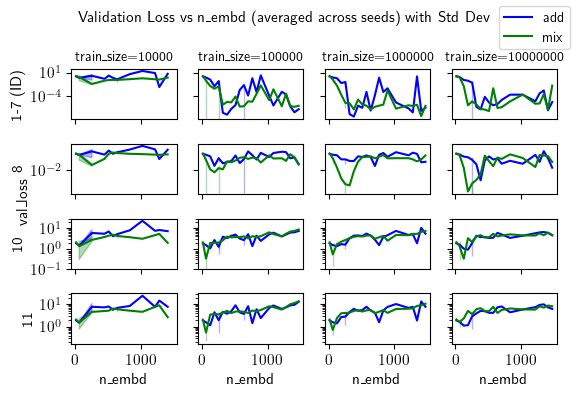

In [10]:
# List of relevant val_loss datasets
datasets = ["add_in_dist", "add_ood_8digit", "add_ood_10digit", "add_ood_11digit"]
train_sizes = [
    10000,
    100000,
    1000000,
    10000000,
]

# Prepare subplots with shared y axes only within rows and shared x axes for all
fig, axes = plt.subplots(
    len(datasets), len(train_sizes), sharex=True, sharey="row", figsize=(5.8, 4.0)
)
fig.suptitle("Validation Loss vs n_embd (averaged across seeds) with Std Dev")

# Define line colors for different tasks
task_colors = {"add": "blue", "mix": "green"}

# Loop over datasets (rows) and train sizes (columns) to create subplots
for i, dataset in enumerate(datasets):
    for j, train_size in enumerate(train_sizes):
        for task_type, color in task_colors.items():
            # Filter data for the dataset, task, and train size
            subset = df[(df["task"] == task_type) & (df["train_size"] == train_size)]

            if subset.empty:
                continue  # Skip if no data is available for the combination

            # Group by 'n_embd', calculate mean and standard deviation of val_loss for each group
            grouped = (
                subset.groupby(["n_embd", "task", "train_size"])[f"val_loss/{dataset}"]
                .agg(["mean", "std"])
                .reset_index()
            )
            grouped = grouped.sort_values(
                "n_embd"
            )  # Sort by n_embd for proper line plotting

            # Plot mean val_loss with a shaded area for the standard deviation
            axes[i, j].plot(
                grouped["n_embd"],
                grouped["mean"],
                label=f"{task_type}",
                color=color,
            )
            axes[i, j].fill_between(
                grouped["n_embd"],
                grouped["mean"] - grouped["std"],
                grouped["mean"] + grouped["std"],
                color=color,
                alpha=0.3,
            )

            # Set logarithmic scale for y-axis
            axes[i, j].set_yscale("log")

            # Set title for each column in the first row only (train sizes)
            if i == 0:
                axes[i, j].set_title(f"train_size={train_size}", fontsize=10)

# Set x-axis labels only for the last row
for ax in axes[-1, :]:
    ax.set_xlabel("n_embd", fontsize=11)

# Set dataset labels only for the left side of the first column subplots
dataset_map = {
    "add_in_dist": "1-7 (ID)",
    "add_ood_8digit": "8",
    "add_ood_10digit": "10",
    "add_ood_11digit": "11",
}
for i, dataset in enumerate(datasets):
    axes[i, 0].set_ylabel(dataset_map[dataset], fontsize=11, rotation=90)

# Add a single y-axis label for the whole figure
fig.text(0.04, 0.5, "val_loss", va="center", rotation="vertical", fontsize=11)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10)

plt.tight_layout()  # Adjust layout to fit the legend and labels
plt.savefig("../latex/fig/exp_27_val_loss_vs_n_embd.png", dpi=300)
plt.show()

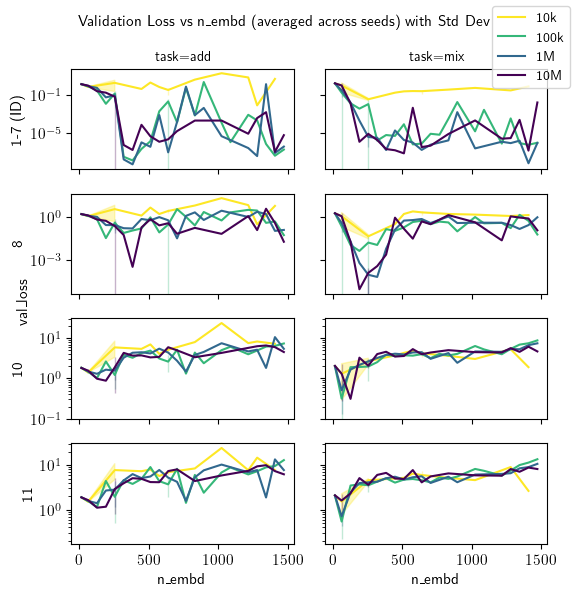

In [9]:
# List of relevant val_loss datasets
datasets = ["add_in_dist", "add_ood_8digit", "add_ood_10digit", "add_ood_11digit"]
train_sizes = [
    10000,
    100000,
    1000000,
    10000000,
]
tasks = ["add", "mix"]

train_size_map = {
    10000: "10k",
    100000: "100k",
    1000000: "1M",
    10000000: "10M",
}

# Prepare subplots with shared y axes only within rows and shared x axes for all
fig, axes = plt.subplots(
    len(datasets), len(tasks), sharex=True, sharey="row", figsize=(5.8, 6)
)
fig.suptitle("Validation Loss vs n_embd (averaged across seeds) with Std Dev")

# get colormap for train sizes
# colors = plt.cm.get_cmap("cividis", len(train_sizes))
cmap = plt.get_cmap("viridis_r", len(train_sizes))
colors = [cmap(i) for i in range(len(train_sizes))]

# Loop over datasets (rows) and train sizes (columns) to create subplots
for i, dataset in enumerate(datasets):
    for j, task in enumerate(tasks):
        for train_size, color in zip(train_sizes, colors):
            # Filter data
            subset = df[(df["task"] == task) & (df["train_size"] == train_size)]

            if subset.empty:
                continue  # Skip if no data is available for the combination

            # Group by 'n_embd', calculate mean and standard deviation of val_loss for each group
            grouped = (
                subset.groupby(["n_embd", "task", "train_size"])[f"val_loss/{dataset}"]
                .agg(["mean", "std"])
                .reset_index()
            )
            grouped = grouped.sort_values(
                "n_embd"
            )  # Sort by n_embd for proper line plotting

            # Plot mean val_loss with a shaded area for the standard deviation
            axes[i, j].plot(
                grouped["n_embd"],
                grouped["mean"],
                label=train_size_map[train_size],
                color=color,
            )
            axes[i, j].fill_between(
                grouped["n_embd"],
                grouped["mean"] - grouped["std"],
                grouped["mean"] + grouped["std"],
                color=color,
                alpha=0.3,
            )

            # Set logarithmic scale for y-axis
            axes[i, j].set_yscale("log")

            # Set title for each column in the first row only (task)
            if i == 0:
                axes[i, j].set_title(f"task={task}", fontsize=10)

# Set x-axis labels only for the last row
for ax in axes[-1, :]:
    ax.set_xlabel("n_embd", fontsize=11)

# Set dataset labels only for the left side of the first column subplots
dataset_map = {
    "add_in_dist": "1-7 (ID)",
    "add_ood_8digit": "8",
    "add_ood_10digit": "10",
    "add_ood_11digit": "11",
}
for i, dataset in enumerate(datasets):
    axes[i, 0].set_ylabel(dataset_map[dataset], fontsize=11, rotation=90)

# Add a single y-axis label for the whole figure
fig.text(0.04, 0.5, "val_loss", va="center", rotation="vertical", fontsize=11)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10)

plt.tight_layout()  # Adjust layout to fit the legend and labels
# plt.savefig("../latex/fig/exp_27_val_loss_vs_n_embd_by_task.png", dpi=300)
plt.show()